In [462]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('monthly_ae_waitingtimes_202212.csv')

# dropping QF columns as data is either nan or z which means not applicable
# dropping Country as it is all just the code for Scotland
df.drop(['NumberOfAttendancesEpisodeQF','NumberMeetingTargetEpisodeQF','DischargeDestinationAdmissionToSameQF',
'DischargeDestinationOtherSpecialtyQF','DischargeDestinationResidenceQF','DischargeDestinationTransferQF',
'DischargeDestinationUnknownQF','AttendanceGreater8hrsQF','AttendanceGreater12hrsQF','Country'], axis=1, inplace=True)

df.sample(5)

,Month,HBT,TreatmentLocation,DepartmentType,NumberOfAttendancesAggregate,NumberOfAttendancesEpisode,NumberMeetingTargetAggregate,NumberMeetingTargetEpisode,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown,AttendanceGreater8hrs,AttendanceGreater12hrs
5537,201206,S08000019,V217H,Emergency Department,5111,5111.0,4860,4860.0,1174.0,6.0,3665.0,31.0,235.0,7.0,0.0
6586,201305,S08000020,N431H,Minor Injury Unit or Other,77,NaN,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2573,200911,S08000016,B103H,Minor Injury Unit or Other,19,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5360,201204,S08000020,N432H,Minor Injury Unit or Other,35,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3568,201009,S08000022,C113H,Minor Injury Unit or Other,355,NaN,347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Replacing names of 'TreatmentLocation' and 'HBT' codes with Hospital and Area names from code file 

In [463]:
# creating list of 'TreatmentLocation' codes from main df
code_list = list(df['TreatmentLocation'].unique())

# retrieving codes and corresponding hospital names from code file
df_hospitals = pd.read_csv('current-hospital_flagged20211216.csv')
df_hospitals = df_hospitals.iloc[0:,:2]

# Use boolean indexing to filter the dataframe from codes in main df
df_filtered = df_hospitals[df_hospitals['Location'].isin(code_list)]

# creating list of codes and names then merging in dictionary 
Location_codes = []
Location_names = []

for index, row in df_filtered.iterrows():
    Location_codes.append(row['Location'])
    Location_names.append(row['LocationName'])

location_dict = dict(zip(Location_codes, Location_names))

# replacing code in main df with corresponding name to code in dictionary
df['LocationName'] = df['TreatmentLocation'].map(location_dict)
df.drop('TreatmentLocation', axis=1, inplace = True)

# dropping rows with missing data
df.dropna(inplace=True)

# repeating previous steps for HBT codes
HBT_codes = list(df['HBT'].unique())

df_hbt_codes = pd.read_csv('hb14_hb19.csv')
df_hbt_codes = df_hbt_codes.iloc[0:,:2]

df_hbt_filtered = df_hbt_codes[df_hbt_codes['HB'].isin(HBT_codes)]

HBT_code_list = []
HBT_name_list = []

for index, row in df_hbt_filtered.iterrows():
    HBT_code_list.append(row['HB'])
    HBT_name_list.append(row['HBName'])

hbt_location_dict = dict(zip(HBT_code_list, HBT_name_list))
df['Area'] = df['HBT'].map(hbt_location_dict)
df.drop('HBT', axis=1, inplace=True)


Reseting index number after dropping rows

In [464]:
df = df.reset_index(drop=True)
df.index = df.index + 1


After breifly glancing at data i saw that all the values i could see for the columns which had an aggregate and episode number for the same category were the same, so i ran this code to check whether all the rows were infact the same:

In [465]:
for index, row in df.iterrows():
    if not df.loc[index, 'NumberOfAttendancesAggregate'] == df.loc[index, 'NumberOfAttendancesEpisode']:
        print(f"Rows {index}: NumberOfAttendancesAggregate and NumberOfAttendancesEpisode are not equal.")

for index, row in df.iterrows():
    if not df.loc[index, 'NumberMeetingTargetAggregate'] == df.loc[index, 'NumberMeetingTargetEpisode']:
        print(f"Rows {index}: NumberMeetingTargetAggregate and NumberMeetingTargetEpisode are not equal.")

Rows 7291: NumberOfAttendancesAggregate and NumberOfAttendancesEpisode are not equal.
Rows 7588: NumberOfAttendancesAggregate and NumberOfAttendancesEpisode are not equal.
Rows 7291: NumberMeetingTargetAggregate and NumberMeetingTargetEpisode are not equal.
Rows 7588: NumberMeetingTargetAggregate and NumberMeetingTargetEpisode are not equal.


since these are the only 2 rows where the aggregate and episode levels are not the same, i will drop the aggregate column, as the episode level column is more specific and represents the number of attendances for new conditions or injuries

In [466]:
df.drop(['NumberOfAttendancesAggregate','NumberMeetingTargetAggregate'], axis=1, inplace=True)

Since the target wait time ias decribed as less than 4 hours, and the columns 'AttendanceGreater8hrs' and 'AttendanceGreater12hrs' are decribed as being 'over' 8 and 12 hours, it would seem that those who waited between 4 and 8 hours are unaccounted for, so i create a new column for the unnaccounted wait times by subtracting the number of <4, >8 and >12 wait times from the total number of attendees. 

In [467]:
df['UnaccountedAttendanceWait'] = df['NumberOfAttendancesEpisode'] - df['NumberMeetingTargetEpisode'] - df['AttendanceGreater8hrs'] - df['AttendanceGreater12hrs']

Reordering columns for cleaner viewing

In [468]:
columns = ['Month','DepartmentType', 'LocationName', 'Area', 'NumberOfAttendancesEpisode','NumberMeetingTargetEpisode',
'AttendanceGreater8hrs', 'AttendanceGreater12hrs', 'UnaccountedAttendanceWait', 'DischargeDestinationAdmissionToSame', 'DischargeDestinationOtherSpecialty',
'DischargeDestinationResidence', 'DischargeDestinationTransfer', 'DischargeDestinationUnknown']

df = df[columns]

Converting 'Month' column and adding new 'Year' column

In [469]:
# convert Month column to datetime format
df['Month'] = pd.to_datetime(df['Month'], format='%Y%m')

# convert Month column to 'month-year' format
df['Month'] = df['Month'].dt.strftime('%m-%Y')

# creating new 'Year' column
df['Year'] = pd.to_datetime(df['Month'], format='%m-%Y').dt.year

In [470]:
df.head()

,Month,DepartmentType,LocationName,Area,NumberOfAttendancesEpisode,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown,Year
1,07-2007,Emergency Department,University Hospital Crosshouse,NHS Ayrshire and Arran,5414.0,5290.0,26.0,24.0,74.0,1985.0,11.0,3374.0,44.0,0.0,2007
2,07-2007,Emergency Department,University Hospital Ayr,NHS Ayrshire and Arran,3530.0,3355.0,3.0,1.0,171.0,106.0,0.0,3369.0,8.0,47.0,2007
3,07-2007,Emergency Department,Borders General Hospital,NHS Borders,1823.0,1804.0,0.0,0.0,19.0,571.0,1.0,1033.0,27.0,191.0,2007
4,07-2007,Emergency Department,Dumfries & Galloway Royal Infirmary,NHS Dumfries and Galloway,2970.0,2862.0,0.0,0.0,108.0,900.0,5.0,1984.0,19.0,62.0,2007
5,07-2007,Emergency Department,Victoria Hospital,NHS Fife,3912.0,3703.0,6.0,1.0,202.0,677.0,53.0,3051.0,33.0,98.0,2007


In [471]:
df_year = df.groupby('Year').sum()

# removing first row (2007) as data is only from July 2007
df_year = df_year[1:]
df_year.head(20)


/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_60071/2248201376.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('Year').sum()


,NumberOfAttendancesEpisode,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown
Year,,,,,,,,,,
2008,1433575.0,1400355.0,2134.0,465.0,30621.0,369764.0,2696.0,938763.0,21142.0,101210.0
2009,1480206.0,1441955.0,2006.0,288.0,35957.0,368812.0,2411.0,947334.0,26196.0,135453.0
2010,1471148.0,1419490.0,3286.0,418.0,47954.0,353244.0,2239.0,938079.0,34364.0,143222.0
2011,1503666.0,1435265.0,5007.0,791.0,62603.0,348058.0,2121.0,956317.0,48229.0,148941.0
2012,1531383.0,1440609.0,7214.0,1159.0,82401.0,378858.0,2490.0,1043669.0,45493.0,60873.0
2013,1497511.0,1394857.0,7472.0,990.0,94192.0,389792.0,2480.0,1004325.0,44992.0,55922.0
2014,1533919.0,1414477.0,10566.0,1246.0,107630.0,402943.0,2434.0,1039187.0,44651.0,44704.0
2015,1485103.0,1378781.0,12353.0,2460.0,91509.0,391308.0,2346.0,1013295.0,39484.0,38670.0
2016,1531084.0,1434278.0,8771.0,1851.0,86184.0,387401.0,2211.0,1060694.0,39518.0,41260.0


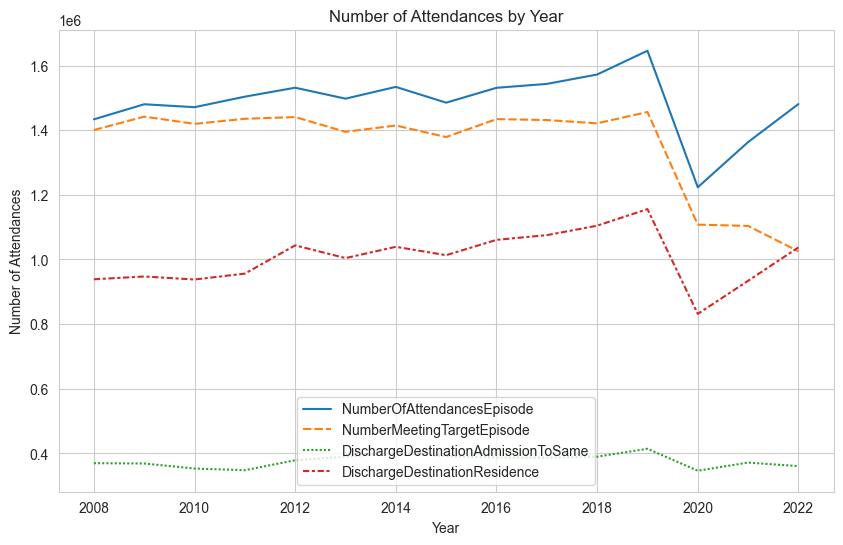

In [472]:
# plot line chart with multiple columns on y-axis
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_year[['NumberOfAttendancesEpisode', 'NumberMeetingTargetEpisode', 'DischargeDestinationAdmissionToSame', 'DischargeDestinationResidence']], ax=ax)
plt.title('Number of Attendances by Year')
plt.ylabel('Number of Attendances')
plt.xlabel('Year')
plt.show()

New dataframe where numbers have been changed to percentages of total patients

In [473]:
df_percent = df.copy()
df_percent['NumberMeetingTargetEpisodePercentage'] = ((df_percent['NumberMeetingTargetEpisode']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['AttendanceGreater8hrsPercentage'] = ((df_percent['AttendanceGreater8hrs']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['AttendanceGreater12hrsPercentage'] = ((df_percent['AttendanceGreater12hrs']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['UnaccountedAttendanceWaitPercentage'] = ((df_percent['UnaccountedAttendanceWait']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['DischargeDestinationAdmissionToSamePercentage'] = ((df_percent['DischargeDestinationAdmissionToSame']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['DischargeDestinationOtherSpecialtyPercentage'] = ((df_percent['DischargeDestinationOtherSpecialty']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['DischargeDestinationResidencePercentage'] = ((df_percent['DischargeDestinationResidence']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['DischargeDestinationTransferPercentage'] = ((df_percent['DischargeDestinationTransfer']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent['DischargeDestinationUnknownPercentage'] = ((df_percent['DischargeDestinationUnknown']/df_percent['NumberOfAttendancesEpisode'])*100).round(2)
df_percent.head()


,Month,DepartmentType,LocationName,Area,NumberOfAttendancesEpisode,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,...,Year,NumberMeetingTargetEpisodePercentage,AttendanceGreater8hrsPercentage,AttendanceGreater12hrsPercentage,UnaccountedAttendanceWaitPercentage,DischargeDestinationAdmissionToSamePercentage,DischargeDestinationOtherSpecialtyPercentage,DischargeDestinationResidencePercentage,DischargeDestinationTransferPercentage,DischargeDestinationUnknownPercentage
1,07-2007,Emergency Department,University Hospital Crosshouse,NHS Ayrshire and Arran,5414.0,5290.0,26.0,24.0,74.0,1985.0,...,2007,97.71,0.48,0.44,1.37,36.66,0.20,62.32,0.81,0.00
2,07-2007,Emergency Department,University Hospital Ayr,NHS Ayrshire and Arran,3530.0,3355.0,3.0,1.0,171.0,106.0,...,2007,95.04,0.08,0.03,4.84,3.00,0.00,95.44,0.23,1.33
3,07-2007,Emergency Department,Borders General Hospital,NHS Borders,1823.0,1804.0,0.0,0.0,19.0,571.0,...,2007,98.96,0.00,0.00,1.04,31.32,0.05,56.66,1.48,10.48
4,07-2007,Emergency Department,Dumfries & Galloway Royal Infirmary,NHS Dumfries and Galloway,2970.0,2862.0,0.0,0.0,108.0,900.0,...,2007,96.36,0.00,0.00,3.64,30.30,0.17,66.80,0.64,2.09
5,07-2007,Emergency Department,Victoria Hospital,NHS Fife,3912.0,3703.0,6.0,1.0,202.0,677.0,...,2007,94.66,0.15,0.03,5.16,17.31,1.35,77.99,0.84,2.51


In [474]:
df_percent.dtypes

Month                                             object
DepartmentType                                    object
LocationName                                      object
Area                                              object
NumberOfAttendancesEpisode                       float64
NumberMeetingTargetEpisode                       float64
AttendanceGreater8hrs                            float64
AttendanceGreater12hrs                           float64
UnaccountedAttendanceWait                        float64
DischargeDestinationAdmissionToSame              float64
DischargeDestinationOtherSpecialty               float64
DischargeDestinationResidence                    float64
DischargeDestinationTransfer                     float64
DischargeDestinationUnknown                      float64
Year                                               int64
NumberMeetingTargetEpisodePercentage             float64
AttendanceGreater8hrsPercentage                  float64
AttendanceGreater12hrsPercentag

In [475]:
# write the DataFrame to a CSV file
df_percent.to_csv('new_monthly_ae_waitingtimes_202212.csv', index=False)

## Grouping by Year and showing data as percentage

In [476]:
df_year_percent = df_percent.groupby('Year').mean().round(2)
df_year_percent.drop('NumberOfAttendancesEpisode', axis=1, inplace=True)
df_year_percent

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_60071/1483436383.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year_percent = df_percent.groupby('Year').mean().round(2)


,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown,NumberMeetingTargetEpisodePercentage,AttendanceGreater8hrsPercentage,AttendanceGreater12hrsPercentage,UnaccountedAttendanceWaitPercentage,DischargeDestinationAdmissionToSamePercentage,DischargeDestinationOtherSpecialtyPercentage,DischargeDestinationResidencePercentage,DischargeDestinationTransferPercentage,DischargeDestinationUnknownPercentage
Year,,,,,,,,,,,,,,,,,,
2007,3059.46,4.91,1.08,95.54,821.22,12.82,2188.15,43.61,95.18,97.57,0.11,0.02,2.30,21.97,0.34,72.98,1.79,2.91
2008,3018.01,4.60,1.00,65.99,796.91,5.81,2023.20,45.56,218.12,98.22,0.11,0.02,1.65,21.46,0.15,68.92,1.75,7.71
2009,2872.42,4.00,0.57,71.63,734.69,4.80,1887.12,52.18,269.83,98.16,0.09,0.01,1.74,19.30,0.13,66.73,1.78,12.06
2010,2750.95,6.37,0.81,92.93,684.58,4.34,1817.98,66.60,277.56,97.59,0.15,0.02,2.23,18.23,0.12,67.75,3.39,10.50
2011,2628.69,9.17,1.45,114.66,637.47,3.88,1751.50,88.33,272.79,97.03,0.21,0.03,2.73,16.82,0.11,68.67,5.09,9.30
2012,2536.28,12.70,2.04,145.07,667.00,4.38,1837.45,80.09,107.17,96.40,0.26,0.04,3.30,17.65,0.12,73.79,4.53,3.90
2013,2473.15,13.25,1.76,167.01,691.12,4.40,1780.72,79.77,99.15,95.82,0.28,0.04,3.87,18.77,0.11,72.61,4.29,4.21
2014,2507.94,18.73,2.21,190.83,714.44,4.32,1842.53,79.17,79.26,95.12,0.40,0.05,4.44,19.27,0.11,73.56,4.25,2.81
2015,2470.93,22.14,4.41,163.99,701.27,4.20,1815.94,70.76,69.30,95.55,0.48,0.10,3.87,18.96,0.11,74.47,4.03,2.43


## Grouping by Area 

In [477]:
df_2022 = df_percent[df_percent['Year'] == 2022]
df_year_percent = df_2022.groupby('Area').mean().round(2)
df_year_percent.drop('NumberOfAttendancesEpisode', axis=1, inplace=True)
df_year_percent

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_60071/2596860273.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year_percent = df_2022.groupby('Area').mean().round(2)


,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown,Year,NumberMeetingTargetEpisodePercentage,AttendanceGreater8hrsPercentage,AttendanceGreater12hrsPercentage,UnaccountedAttendanceWaitPercentage,DischargeDestinationAdmissionToSamePercentage,DischargeDestinationOtherSpecialtyPercentage,DischargeDestinationResidencePercentage,DischargeDestinationTransferPercentage,DischargeDestinationUnknownPercentage
Area,,,,,,,,,,,,,,,,,,,
NHS Ayrshire and Arran,2571.21,584.46,367.46,254.29,970.96,7.12,2495.08,63.83,240.42,2022.0,67.33,16.03,10.03,6.62,25.05,0.19,67.30,2.09,5.37
NHS Borders,1596.67,386.83,258.83,232.42,685.75,5.00,1698.67,75.25,10.08,2022.0,64.60,15.54,10.38,9.47,27.80,0.20,68.55,3.04,0.41
NHS Dumfries and Galloway,1526.04,84.83,21.46,283.04,403.08,2.54,1415.38,44.71,49.67,2022.0,82.29,3.62,0.86,13.22,16.68,0.13,76.86,3.38,2.94
NHS Fife,1282.40,120.54,32.31,322.21,419.10,1.77,1262.60,30.00,43.98,2022.0,91.25,2.17,0.58,6.01,8.16,0.03,88.11,2.28,1.42
NHS Forth Valley,2201.88,408.50,152.04,643.42,765.42,5.62,2291.21,20.08,323.50,2022.0,75.58,8.21,3.06,13.15,15.68,0.12,74.84,0.48,8.88
NHS Grampian,1773.17,243.86,60.69,646.33,676.56,5.31,1942.64,13.19,86.36,2022.0,72.28,6.83,1.85,19.04,21.03,0.16,75.52,0.45,2.84
NHS Greater Glasgow and Clyde,2923.14,316.88,85.34,783.88,937.55,6.77,2924.05,75.18,165.69,2022.0,78.99,5.49,1.52,13.99,17.44,0.13,75.77,2.63,4.02
NHS Highland,918.35,46.80,12.65,165.10,234.48,1.32,826.80,22.52,57.78,2022.0,86.77,2.36,0.68,10.19,17.36,0.13,75.95,3.20,3.36
NHS Lanarkshire,3190.81,742.56,244.58,1302.78,1684.47,6.14,3660.61,84.06,45.44,2022.0,58.24,13.43,4.43,23.90,30.59,0.11,66.93,1.56,0.81


In [478]:
df_location = df_percent.groupby('LocationName').mean().round(2)
df_location

/var/folders/ly/dg_yy0m54vb9my4bfgbtld880000gn/T/ipykernel_60071/3498913945.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_location = df_percent.groupby('LocationName').mean().round(2)


,NumberOfAttendancesEpisode,NumberMeetingTargetEpisode,AttendanceGreater8hrs,AttendanceGreater12hrs,UnaccountedAttendanceWait,DischargeDestinationAdmissionToSame,DischargeDestinationOtherSpecialty,DischargeDestinationResidence,DischargeDestinationTransfer,DischargeDestinationUnknown,Year,NumberMeetingTargetEpisodePercentage,AttendanceGreater8hrsPercentage,AttendanceGreater12hrsPercentage,UnaccountedAttendanceWaitPercentage,DischargeDestinationAdmissionToSamePercentage,DischargeDestinationOtherSpecialtyPercentage,DischargeDestinationResidencePercentage,DischargeDestinationTransferPercentage,DischargeDestinationUnknownPercentage
LocationName,,,,,,,,,,,,,,,,,,,,
Aberdeen Royal Infirmary,4905.72,4390.37,61.73,9.54,444.08,1325.88,15.00,3281.89,41.78,241.17,2014.74,88.93,1.36,0.21,9.50,27.37,0.30,66.55,0.83,4.96
Aberfeldy Cottage Hospital,9.71,9.70,0.00,0.00,0.01,0.08,0.00,5.41,0.91,3.32,2012.08,99.93,0.00,0.00,0.07,0.74,0.00,57.12,9.30,32.84
Adamson Hospital,142.46,141.74,0.03,0.00,0.70,1.18,0.00,123.38,3.03,14.87,2019.32,99.42,0.02,0.00,0.56,0.83,0.00,85.60,2.18,11.38
Arbroath Infirmary,1023.83,1023.19,0.02,0.00,0.62,7.43,0.18,894.47,79.61,42.13,2014.74,99.94,0.00,0.00,0.06,0.84,0.02,87.43,7.57,4.14
Belford Hospital,750.45,711.46,2.15,0.26,36.57,126.50,0.66,600.83,8.34,14.12,2016.58,94.85,0.28,0.04,4.83,17.28,0.09,79.49,1.17,1.97
Blairgowrie & Rattray Cottage Hospital,255.93,255.63,0.04,0.01,0.25,2.78,0.00,234.55,12.78,5.81,2013.37,99.88,0.01,0.00,0.10,1.31,0.00,91.38,4.75,2.55
Borders General Hospital,2209.22,2022.20,41.55,23.63,121.83,738.93,3.43,1252.77,154.55,59.54,2014.74,92.04,1.71,0.96,5.28,33.62,0.16,56.18,7.03,3.02
Brechin Infirmary,217.81,217.69,0.00,0.00,0.12,1.77,0.03,195.52,11.43,9.06,2013.00,99.95,0.00,0.00,0.05,0.80,0.01,90.38,4.96,3.84
Caithness General Hospital,610.38,578.80,3.62,1.13,26.83,158.77,1.04,439.89,7.32,3.37,2016.58,95.13,0.51,0.15,4.20,26.74,0.17,71.54,1.09,0.46
